# Kernel PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

np.random.seed(0)

## Generowanie danych

### Pomocnicze funkcje

In [2]:
def generate_spherical_data(N=200, r1=10, r2=15, sigma_noise=0.1):
    theta = np.random.uniform(0, np.pi, N)  # Uniformly distributed in [0, π]
    phi = np.random.uniform(0, 2*np.pi, N)  # Uniformly distributed in [0, 2π)
    half_N = N // 2

    # Class 1 coordinates
    x1 = r1 * np.sin(theta[:half_N]) * np.cos(phi[:half_N])
    y1 = r1 * np.sin(theta[:half_N]) * np.sin(phi[:half_N])
    z1 = r1 * np.cos(theta[:half_N])
    # Add Gaussian noise
    x1_with_noise = x1 + np.random.normal(0, sigma_noise, half_N)
    y1_with_noise = y1 + np.random.normal(0, sigma_noise, half_N)
    z1_with_noise = z1 + np.random.normal(0, sigma_noise, half_N)
    
    # Class 2 coordinates
    x2 = r2 * np.sin(theta[half_N:]) * np.cos(phi[half_N:])
    y2 = r2 * np.sin(theta[half_N:]) * np.sin(phi[half_N:])
    z2 = r2 * np.cos(theta[half_N:])
    # Add Gaussian noise
    x2_with_noise = x2 + np.random.normal(0, sigma_noise, half_N)
    y2_with_noise = y2 + np.random.normal(0, sigma_noise, half_N)
    z2_with_noise = z2 + np.random.normal(0, sigma_noise, half_N)

    # Combine and label data
    class_1_data = np.stack([x1_with_noise, y1_with_noise, z1_with_noise, np.ones(half_N)], axis=1)
    class_2_data = np.stack([x2_with_noise, y2_with_noise, z2_with_noise, np.zeros(half_N)], axis=1)
    data = np.concatenate([class_1_data, class_2_data], axis=0)

    return data

def plot_spherical_data(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Filter data by class
    class_1_data = data[data[:, 3] == 1]
    class_2_data = data[data[:, 3] == 0]

    # Plot
    ax.scatter(class_1_data[:, 0], class_1_data[:, 1], class_1_data[:, 2], color='blue', label='Class 1')
    ax.scatter(class_2_data[:, 0], class_2_data[:, 1], class_2_data[:, 2], color='red', label='Class 2')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title('3D Plot of Data Points on Two Concentric Spheres with Gaussian Noise')
    plt.show()

### Wygenerowane dane

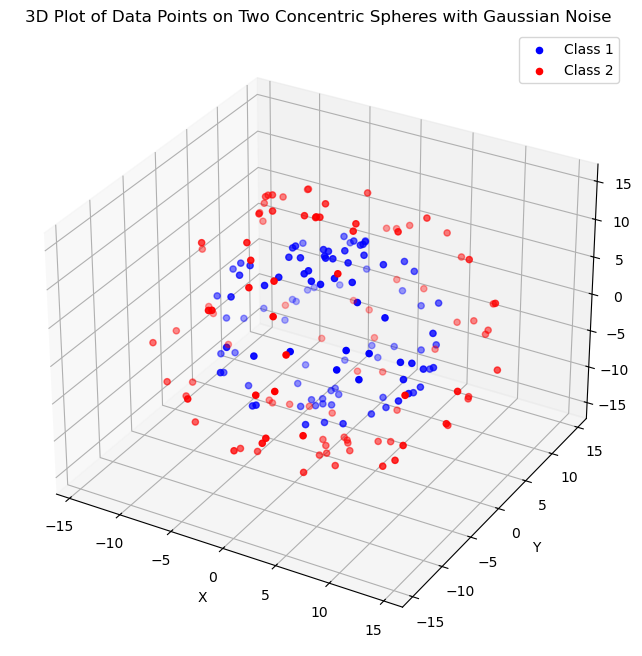

In [3]:
data = generate_spherical_data()

plot_spherical_data(data)

In [4]:
X, y = data[:, :-1], data[:, -1]

## Eksperyment z artykułu

### Kernel PCA z jądrem typu RBF

In [5]:
kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=50)

X_kpca_rbf = kpca_rbf.fit_transform(StandardScaler().fit_transform(X))

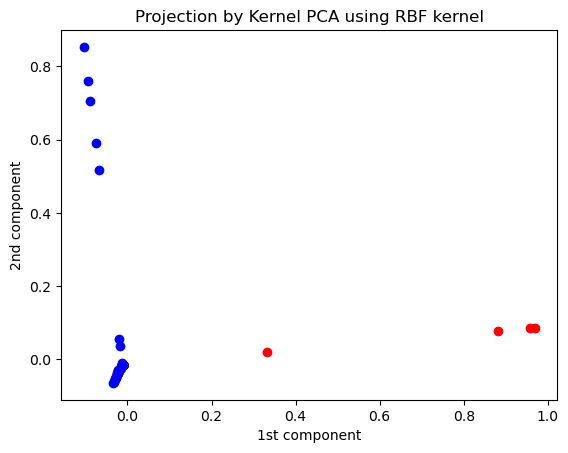

In [6]:
reds = y == 0
blues = y == 1

plt.scatter(X_kpca_rbf[np.array(reds), 0], X_kpca_rbf[np.array(reds), 1], c="red")
plt.scatter(X_kpca_rbf[np.array(blues), 0], X_kpca_rbf[np.array(blues), 1], c="blue")
plt.title("Projection by Kernel PCA using RBF kernel")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

### Kernel PCA z jądrem wielomianowym

In [7]:
kpca_poly = KernelPCA(n_components=2, kernel='poly', degree=5)

X_kpca_poly = kpca_poly.fit_transform(StandardScaler().fit_transform(X))

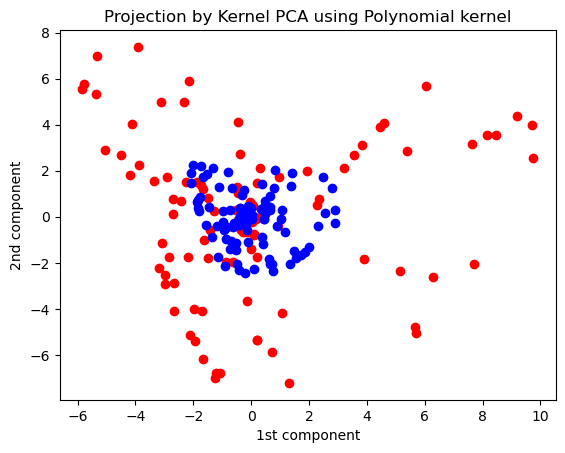

In [8]:
reds = y == 0
blues = y == 1

plt.scatter(X_kpca_poly[np.array(reds), 0], X_kpca_poly[np.array(reds), 1], c="red")
plt.scatter(X_kpca_poly[np.array(blues), 0], X_kpca_poly[np.array(blues), 1], c="blue")
plt.title("Projection by Kernel PCA using Polynomial kernel")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

## Sprawdzanie wpływu zastosowania nieliniowej funkcji redukcji wymiaru na wyniki zadania 7.3 i 7.4

### Przygotowanie danych

In [32]:
lfw_people = fetch_lfw_people(min_faces_per_person=50)

X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, random_state=42)

### Dla 100 komponentów

In [33]:
pca = KernelPCA(n_components=100,  kernel='poly', degree=5).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#### MLP

In [34]:
mlp = MLPClassifier(hidden_layer_sizes=(1024, 512, 256, 128), max_iter=1000, random_state=42)
mlp.fit(X_train_pca, y_train)

y_pred_mlp = mlp.predict(X_test_pca)
report_mlp = classification_report(y_test, y_pred_mlp, target_names=lfw_people.target_names)

print(report_mlp)

                   precision    recall  f1-score   support

     Ariel Sharon       0.61      0.69      0.65        16
     Colin Powell       0.91      0.88      0.89        66
  Donald Rumsfeld       0.70      0.70      0.70        27
    George W Bush       0.91      0.85      0.88       140
Gerhard Schroeder       0.55      0.71      0.62        24
      Hugo Chavez       0.77      0.59      0.67        17
   Jacques Chirac       0.30      0.30      0.30        10
    Jean Chretien       0.71      0.71      0.71        14
    John Ashcroft       0.61      0.69      0.65        16
Junichiro Koizumi       0.82      0.82      0.82        11
  Serena Williams       0.78      0.78      0.78         9
       Tony Blair       0.73      0.80      0.76        40

         accuracy                           0.78       390
        macro avg       0.70      0.71      0.70       390
     weighted avg       0.79      0.78      0.79       390



#### SVM

In [28]:
svm = SVC(class_weight='balanced', random_state=42)
svm.fit(X_train_pca, y_train)

y_pred_svm = svm.predict(X_test_pca)
report_svm = classification_report(y_test, y_pred_svm, target_names=lfw_people.target_names)

print(report_svm)

                   precision    recall  f1-score   support

     Ariel Sharon       0.55      0.69      0.61        16
     Colin Powell       0.79      0.82      0.81        66
  Donald Rumsfeld       0.62      0.67      0.64        27
    George W Bush       0.87      0.68      0.76       140
Gerhard Schroeder       0.50      0.50      0.50        24
      Hugo Chavez       0.71      0.71      0.71        17
   Jacques Chirac       0.55      0.60      0.57        10
    Jean Chretien       1.00      0.86      0.92        14
    John Ashcroft       0.50      0.88      0.64        16
Junichiro Koizumi       0.75      0.82      0.78        11
  Serena Williams       0.67      0.89      0.76         9
       Tony Blair       0.58      0.70      0.64        40

         accuracy                           0.72       390
        macro avg       0.67      0.73      0.70       390
     weighted avg       0.74      0.72      0.72       390



### Dla 50 komponentów

In [13]:
pca = KernelPCA(n_components=50,  kernel='poly', degree=5).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### MLP

In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(1024, 512, 256, 128), max_iter=1000, random_state=42)
mlp.fit(X_train_pca, y_train)

y_pred_mlp = mlp.predict(X_test_pca)
report_mlp = classification_report(y_test, y_pred_mlp, target_names=lfw_people.target_names)

print(report_mlp)

                   precision    recall  f1-score   support

     Ariel Sharon       0.58      0.69      0.63        16
     Colin Powell       0.86      0.82      0.84        66
  Donald Rumsfeld       0.53      0.63      0.58        27
    George W Bush       0.88      0.81      0.84       140
Gerhard Schroeder       0.52      0.58      0.55        24
      Hugo Chavez       0.65      0.65      0.65        17
   Jacques Chirac       0.50      0.30      0.38        10
    Jean Chretien       0.83      0.71      0.77        14
    John Ashcroft       0.67      0.88      0.76        16
Junichiro Koizumi       1.00      0.82      0.90        11
  Serena Williams       0.88      0.78      0.82         9
       Tony Blair       0.63      0.72      0.67        40

         accuracy                           0.75       390
        macro avg       0.71      0.70      0.70       390
     weighted avg       0.76      0.75      0.75       390



#### SVM

In [15]:
svm = SVC(class_weight='balanced', random_state=42)
svm.fit(X_train_pca, y_train)

y_pred_svm = svm.predict(X_test_pca)
report_svm = classification_report(y_test, y_pred_svm, target_names=lfw_people.target_names)

print(report_svm)

                   precision    recall  f1-score   support

     Ariel Sharon       0.35      0.50      0.41        16
     Colin Powell       0.77      0.71      0.74        66
  Donald Rumsfeld       0.57      0.63      0.60        27
    George W Bush       0.87      0.65      0.74       140
Gerhard Schroeder       0.39      0.38      0.38        24
      Hugo Chavez       0.53      0.59      0.56        17
   Jacques Chirac       0.42      0.50      0.45        10
    Jean Chretien       0.77      0.71      0.74        14
    John Ashcroft       0.43      0.81      0.57        16
Junichiro Koizumi       0.75      0.82      0.78        11
  Serena Williams       0.67      0.89      0.76         9
       Tony Blair       0.52      0.65      0.58        40

         accuracy                           0.65       390
        macro avg       0.59      0.65      0.61       390
     weighted avg       0.69      0.65      0.66       390



Zastosowanie nieliniowej redukcji wymiaru za pomocą kernel PCA nie poprawia wyników klasyfikacji z zadania 7.3. oraz 7.4. W przypadku wielomianowego jądra, zwiększanie stopnia wielomianu pogarsza wyniki (im wyższy stopień, tym accuracy jest niższe). Zastosowanie jądra rbf skutkuje błędem związanym z dzieleniem przez 0.